# TICA & Deep-TICA - Toy model

Data-driven collective variables optimized as to match the slow dynamical modes of the system, using a linear combination or a neural network as basis function.

**System**: Wolfe-Quapp 2D potential (rotated), standard molecular dynamics simulation

## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from mlcvs.utils.io import load_dataframe

Helper function to load data

In [2]:
def load_dataset_2d_model():
    """Load trajectory of Langevin dynamics on 2d toy model"""

    # Load data
    data = load_dataframe("data/2d_model/COLVAR_md")
    data = data[::50]

    X = data.filter(regex='p.').values
    names = data.filter(regex="p.*").columns.values
    t = data['time'].values

    return X, t, names

Plotting functions

In [3]:
def plot_isolines_grid(cv,limits=((-3,3),(-3,3)),num_points=(50,50),scatter=None,axs=None):

    if type(num_points) == int:
        num_points = (num_points,num_points)

    # Get number of outputs
    params = cv.get_params()
    if 'n_hidden' in params:
        n_out = params['n_hidden']
    else:
        n_out = params['n_features']

    # Define grid and evaluate cv on it
    xx = np.linspace(limits[0][0],limits[0][1],num_points[0])
    yy = np.linspace(limits[1][0],limits[1][1],num_points[1])
    xv, yv = np.meshgrid(xx, yy, indexing='xy')
    z = [ np.zeros_like(xv) for _ in range(n_out) ]
    for i in range(num_points[0]):
        for j in range(num_points[1]):
            xy = torch.Tensor([xv[i,j], yv[i,j]])
            for k in range(n_out):
                z[k][i,j] = cv(xy)[k]

    # Setup plot
    if axs is None:
        _, axs = plt.subplots(figsize=(5,4.*n_out), dpi=100)
        for k,ax in enumerate(axs):
            axs.set_title(f'{cv.name_} {k+1} isolines')

    # Plot countour plot
    for k,ax in enumerate(axs):
        h = ax.contourf(xx, yy, z[k])
        cbar = plt.colorbar(h,ax=ax)
        cbar.set_label(f'{cv.name_} {k+1}')

    # Scatter plot with training data
    if scatter is not None:
        for ax in axs:
            ax.scatter(scatter[:,0],scatter[:,1],s=2,c='white',alpha=0.5)
            ax.set_aspect('equal') 

def plot_cv_histogram(s,label=None,ax=None,**kwargs):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title('Histogram')

    if (type(s)==torch.Tensor):
        if s.ndim == 2:
            s = s.squeeze(1)
        s = s.detach().numpy()

    # Plot histogram
    ax.hist(s,**kwargs)
    if label is not None:
        ax.set_xlabel(label)


## Linear Time-lagged independent component analysis (TICA) CVs

References:
1. _Schwantes, Pande, JCTC 2013_.
2. _Pérez-Hernández, ... Noe, JCP 2013_.
3. _McCarty, Parrinello, JCP 2017_.

### Load data

In [4]:
X, t, feature_names = load_dataset_2d_model()

### Train CV

In [10]:
from mlcvs.tica import TICA_CV

tica = TICA_CV(n_features=X.shape[1])

# to illustrate the usage with biased simulations (although this one has no bias)
bias = np.zeros_like(t)

lag = 50
tica.fit(X, t, lag=lag, logweights=bias)

In [11]:
# Get implied timescales
tica.tica.timescales(lag=100)

tensor([1191.6388,   21.0911])

### Plot results

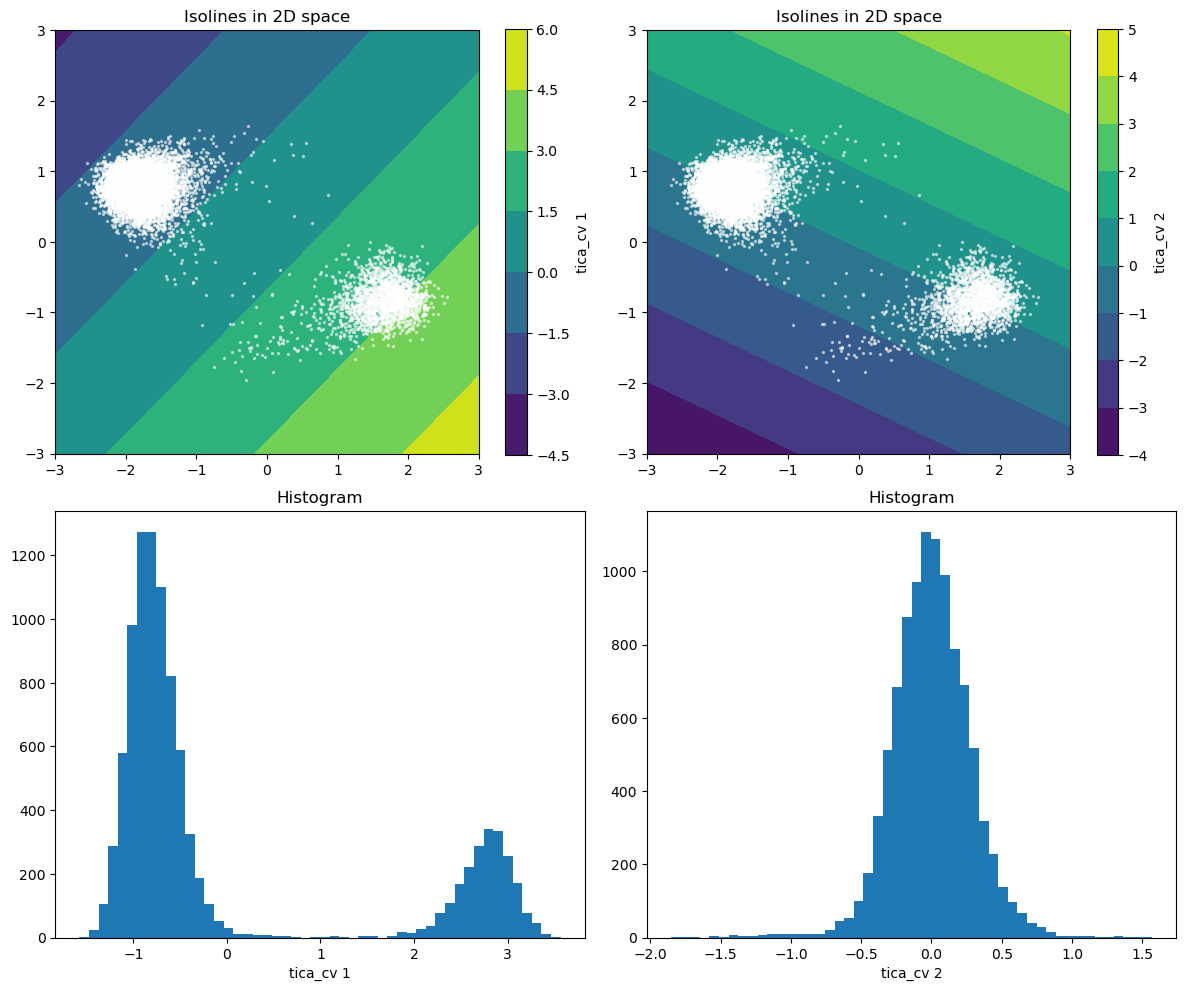

In [7]:
_, axs = plt.subplots(2,2, figsize=(12,10), dpi=100)

# CV isolines
for ax in axs[0]:
    ax.set_title(f'Isolines in 2D space')
    ax.set_title(f'Isolines in 2D space')
plot_isolines_grid(tica, scatter=X, num_points=50, axs=axs[0])

# Calculate CV values over training set
for ax in axs[1]:
    ax.set_title(f'Histogram')

s = tica(X)
for k,ax in enumerate(axs[1]):
    plot_cv_histogram(s[:,k], label=tica.name_+' '+str(k+1),bins=50, ax=ax )

plt.tight_layout()


### Get PLUMED input

In [91]:
tica.set_params({"feature_names": feature_names})
print( tica.plumed_input() )

tica_cv1: CUSTOM ARG=p.x,p.y VAR=x0,x1 FUNC=+0.721355*(x0+1.031899)-0.692565*(x1-0.411431) PERIODIC=NO
tica_cv2: CUSTOM ARG=p.x,p.y VAR=x0,x1 FUNC=+0.429506*(x0+1.031899)+0.903064*(x1-0.411431) PERIODIC=NO



## Deep-TICA: Use a neural network ansatz to approximate the slow modes

Reference: _Bonati, Piccini, Parrinello, PNAS 2021_.

### Load data

In [9]:
from mlcvs.utils.data import create_time_lagged_dataset, FastTensorDataLoader
from torch.utils.data import Subset,random_split

X, t, feature_names = load_dataset_2d_model()
n_features = X.shape[1]

lag_time = 50

# to illustrate the usage with biased simulations (although this one has no bias)
bias = np.zeros_like(t)

# create dataset
dataset = create_time_lagged_dataset(X,t=t,lag_time=lag_time,logweights=bias)

# split train - valid 
n_train  = int( 0.9 * len(dataset) )
n_valid  = len(dataset) - n_train
train_data, valid_data = random_split(dataset,[n_train,n_valid]) 
#train_data = Subset(dataset, np.arange(2*n_train))
#valid_data = Subset(dataset, np.arange(2*n_train,len(dataset)))

# create dataloaders 
train_loader = FastTensorDataLoader(train_data, batch_size=len(train_data))
valid_loader = FastTensorDataLoader(valid_data, batch_size=len(valid_data))

print('Time-lagged pairs:\t',len(dataset))
print('Training data:\t\t',len(train_data))
print('Validation data:\t',len(valid_data))

Time-lagged pairs:	 9997
Training data:		 8997
Validation data:	 1000


### Train CV

In [116]:
from mlcvs.tica import DeepTICA_CV

model = DeepTICA_CV(layers=[2,10,2])
model.set_earlystopping(patience=20)
model.fit(train_loader, valid_loader, 
            loss_type='sum',
            nepochs=1000, log_every=10)

Epoch Train Loss  Valid Loss  Eigenvalues             
10    -0.963      -0.880      0.936  0.023  
20    -0.963      -0.891      0.940  0.022  
30    -0.964      -0.899      0.943  0.022  
40    -0.966      -0.905      0.944  0.022  
50    -0.967      -0.908      0.945  0.022  
60    -0.968      -0.910      0.946  0.022  
70    -0.969      -0.912      0.946  0.022  
80    -0.969      -0.914      0.947  0.022  
90    -0.970      -0.916      0.947  0.022  
100   -0.971      -0.917      0.948  0.023  
110   -0.971      -0.919      0.948  0.023  
120   -0.972      -0.920      0.948  0.023  
130   -0.972      -0.921      0.949  0.023  
140   -0.972      -0.922      0.949  0.023  
150   -0.972      -0.923      0.949  0.023  
160   -0.972      -0.924      0.949  0.023  
170   -0.972      -0.924      0.949  0.023  
180   -0.973      -0.923      0.949  0.023  
INFO: Early stopping
181   -0.973      -0.923      0.949  0.023  


### Plot learning curve

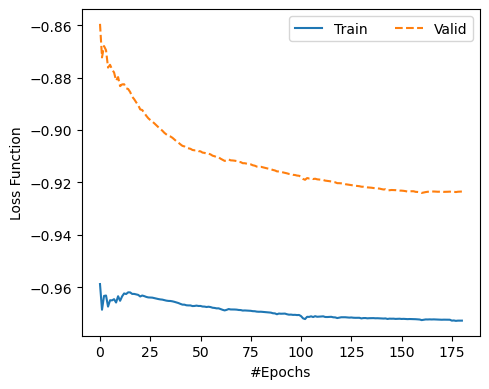

In [117]:
fig, ax = plt.subplots(figsize=(5,4),dpi=100)

loss_train = [x.cpu() for x in model.loss_train]
loss_valid = [x.cpu() for x in model.loss_valid]

# Loss function
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')

#if model.earlystopping_.early_stop:
#    ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
ax.set_xlabel('#Epochs')
ax.legend(ncol=2)

plt.tight_layout()
plt.show()

### Plot results

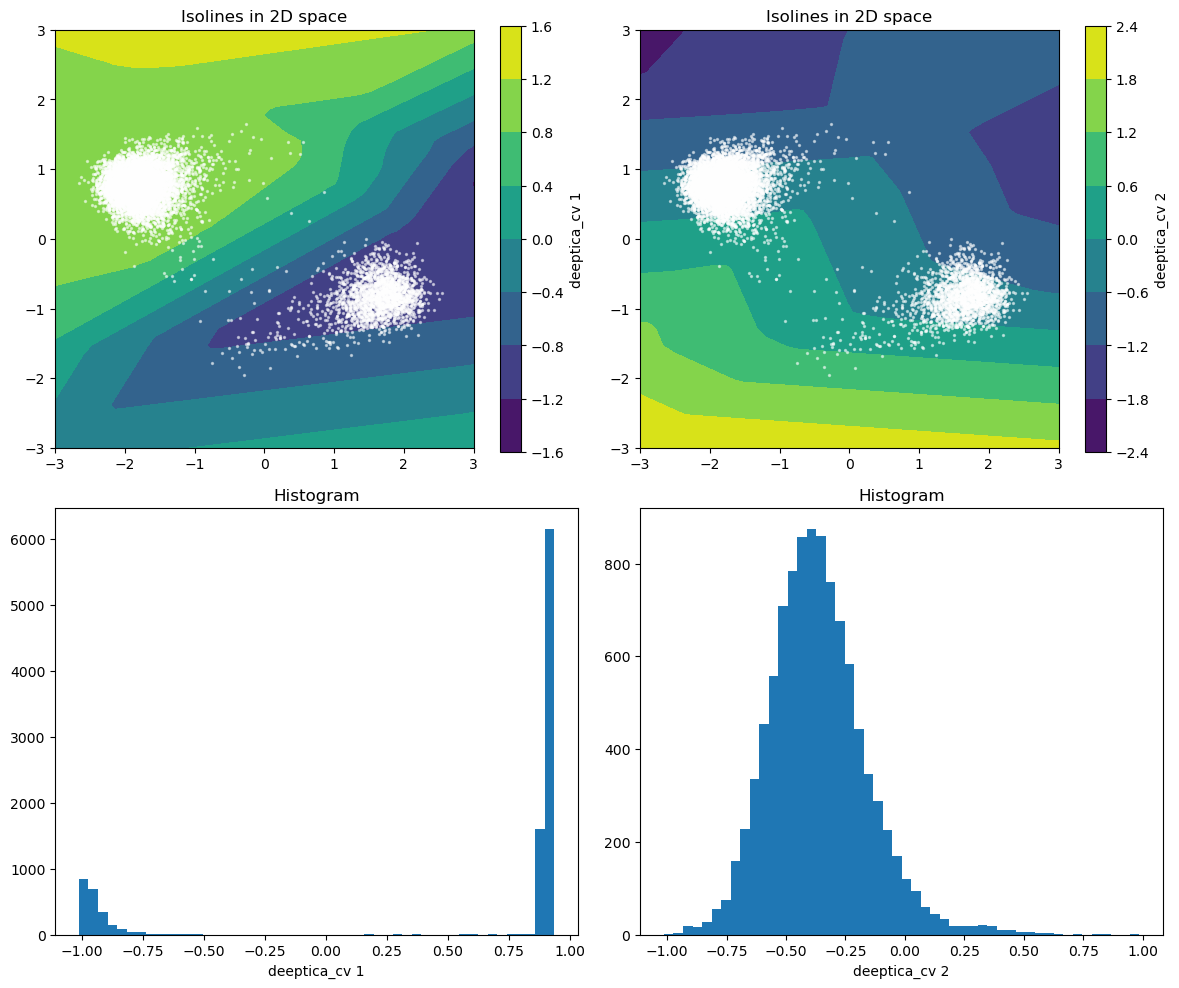

In [118]:
_, axs = plt.subplots(2,2, figsize=(12,10), dpi=100)

# CV isolines
for ax in axs[0]:
    ax.set_title(f'Isolines in 2D space')
    ax.set_title(f'Isolines in 2D space')
plot_isolines_grid(model, scatter=X, num_points=50, axs=axs[0])

# Calculate CV values over training set
for ax in axs[1]:
    ax.set_title(f'Histogram')

s = model(torch.Tensor(X))
for k,ax in enumerate(axs[1]):
    plot_cv_histogram(s[:,k], label=model.name_+' '+str(k+1),bins=50, ax=ax )

plt.tight_layout()
